## RNN(recurrent neural network, 순환신경망)
앞서 배운 신경망들은 모든 신호가 오직 출력층 방향으로만 향하고 있었다.  
이런 신경망들을 feedforward 신경망이라고 하는데, 한 시점의 이미지나 정보만을 이용한다는 단점이 있다.  


RNN은 시간에 따라 순차적으로 제공되는 정보를 다룰 수 있는 신경망으로, 다양한 분야에서 널리 이용되고 있다.  
RNN을 구성하는 뉴런들은 활성화함수를 통해 나온 출력이 다시 자기자신에게 입력으로 제공되는 구조이다.  
이런 뉴런은 시간의 흐름에 따라 연속적으로 발생하는 신호를 보고, 다음 신호를 예측하는 일에 좋은 성능을 보인다.  
RNN의 대표적 응용사례는 네이버의 파파고 같은 기계번역 프로그램이다.  
입력과 출력 모두 sequence로, 글자나 단어들이 순서를 가지고 연속적으로 나타난다.  
1:m, n:1, n:m 의 다양한 기법이 있다.


+ 첫번째 cell : x1 입력 => h1 출력
+ 두번째 cell : x2 입력 + h1 => h2
+ 세번째 cell : x3 입력 + h2 => h3 ....


모든 layer(=순환cell)는 이전 상태 정보를 보존하는 기능과, 다음 층으로 정보를 전달하는 구조를 가지며,  
신호가 전달될 때는 학습을 통해 변경되는 weight가 곱해져서 전달된다.


하나의 셀은 (자신의 이전 셀에서 얻은 입력 + 새롭게 제공된 입력)을 하나의 활성화함수에 제공한다.  
활성화함수는 일반적으로 tanh를 사용하며, 그 결과는 노드의 출력 h가 되어 순환edge를 통해 자신에게 feedback된다.
+ tanh를 사용하는 이유?
    + ReLU를 사용하면 feedback 구조 때문에 신호가 지나치게 커지는 overflow가 발생할 수 있다.
    + tanh, sigmoid의 경우 값이 특정 범위를 넘지 못하게 되어있어 위 문제를 피할 수 있다.
    + tanh가 sigmoid보다 기울기소실 문제를 더 잘 해결한다.

### Tensorflow로 단순 RNN 모델 만들기
+ 입력 : [0.0, 0.1, 0.2] 처럼 3개의 원소를 가지는 시퀀스 데이터
+ 목표값 : 0.3 처럼 하나의 실수 레이블 값

In [111]:
import numpy as np

size, seq_len = 100, 3

X = np.empty(shape=(size, seq_len, 1))   #(100, 3, 1)
Y = np.empty(shape=(size,))              #(100,)

for i in range(size):
    c = np.linspace(i/10, (i+seq_len-1)/10.0, seq_len)   #(3, )
    X[i] = c[:, np.newaxis]   #(3, 1)
    Y[i] = (i+seq_len)/10
    
for i in range(5):
    print(X[i], Y[i])

[[0. ]
 [0.1]
 [0.2]] 0.3
[[0.1]
 [0.2]
 [0.3]] 0.4
[[0.2]
 [0.3]
 [0.4]] 0.5
[[0.3]
 [0.4]
 [0.5]] 0.6
[[0.4]
 [0.5]
 [0.6]] 0.7


In [112]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([keras.layers.SimpleRNN(units=20, input_shape=[3,1],  #layer에 있는 뉴런 유닛의 수, 입력형태는 [seq_len,1]로 각각이 모두 출력을 발생시킴
                                                 return_sequences=False),      #출력으로 시간시리즈에 걸친 시퀀스 전체를 출력할지
                          keras.layers.Dense(1)])   #20개의 유닛의 각 출력들을 하나의 레이블 값으로 만들기 위해 출력노드 개수를 1로 지정

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 20)                440       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


(유닛 20개 x 순환에지 20개) + 입력을 각 유닛에 보내는 연결 20개 + 각 유닛의 출력을 위한 연결 20개  
=> 이 신경망을 위한 파라미터는 총 440개

이 계층의 출력 20개 + 편향 1개  
=> 출력을 위한 연결망을 위한 파라미터는 총 21개  


=> total params : 461

In [113]:
history = model.fit(X, Y, epochs=300, verbose=0)

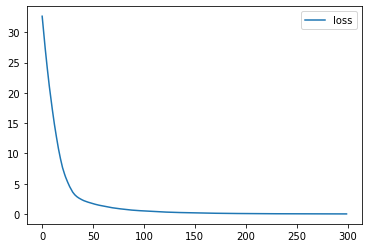

In [114]:
import pandas as pd

pd.DataFrame(history.history).plot();

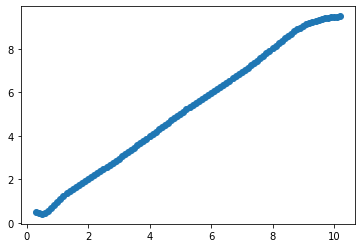

In [115]:
import matplotlib.pyplot as plt

y_pred = model.predict(X)

plt.scatter(Y, y_pred);   

y=x 직선에 가까울수록 정확도가 높은데, 상당한 오차가 있어보인다.  
새로운 데이터를 입력해 예측해보자.

In [116]:
new_data = [[[[10.2], [10.3], [10.4]],
            [[10.4], [10.5], [10.6]]]]

y_pred = [model.predict(i) for i in new_data]

y_pred   #정답은 10.5, 10.7인데 상당한 오차가 있다.

[array([[9.526612],
        [9.541211]], dtype=float32)]

모델의 예측 성능을 개선하기 위해 유닛 수를 늘려보자.  
유닛이 증가하면 모델의 훈련 파라미터도 증가할 것이다.  
+ 유닛 20개 => 훈련 파라미터 (20 x 20) + (20 x 2) + (20 + 1) = 461개  
+ 유닛 256개 => (256 x 256) + (256 x 2) + (256 + 1) = 66305개

In [117]:
model = keras.Sequential([keras.layers.SimpleRNN(units=256, input_shape=[3,1],  
                                                 return_sequences=False),     
                          keras.layers.Dense(1)])   

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 256)               66048     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


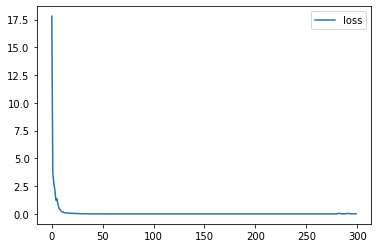

In [118]:
history = model.fit(X, Y, epochs=300, verbose=0)

pd.DataFrame(history.history).plot();

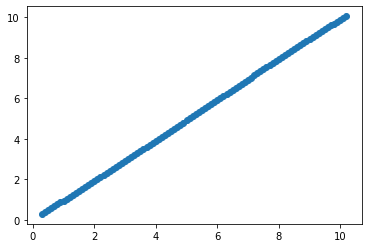

In [119]:
y_pred = model.predict(X)

plt.scatter(Y, y_pred);

In [120]:
y_pred = [model.predict(i) for i in new_data]

y_pred   #정답 10.5, 10.7에 가깝게 예측해냈다.

[array([[10.318953],
        [10.486453]], dtype=float32)]

### RNN을 다층구조로 만들어 적은 파라미터로도 좋은 성능 내기
위에서는 하나의 층을 가진 RNN에서 유닛 수만 늘려보았는데,  
이번에는 유닛은 적은 수로 유지하면서 층을 여러개 쌓아보자.  
+ 출력으로 시간시리즈에 걸친 시퀀스 전체를 다음 층으로 전달해야하므로 return_sequences=True로 설정할 것!

In [121]:
model = keras.Sequential([keras.layers.SimpleRNN(units=32, input_shape=[3,1], return_sequences=True),   #(32x32) + (32x2) = 1088
                          keras.layers.SimpleRNN(units=32, input_shape=[3,1], return_sequences=True),   #(32x32) + (32x32) + 32 = 2080
                          keras.layers.SimpleRNN(units=32, input_shape=[3,1], return_sequences=True),   #(32x32) + (32x32) + 32 = 2080
                          keras.layers.SimpleRNN(units=32, input_shape=[3,1]),                          #(32x32) + (32x32) + 32 = 2080
                          keras.layers.Dense(1)])                                                       #32 + 1 = 33

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_14 (SimpleRNN)    (None, 3, 32)             1088      
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 3, 32)             2080      
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 3, 32)             2080      
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


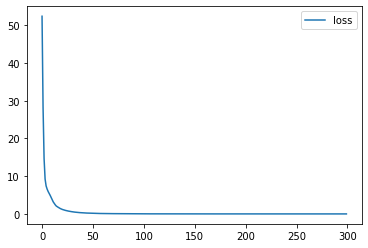

In [122]:
history = model.fit(X, Y, epochs=300, verbose=0)

pd.DataFrame(history.history).plot();

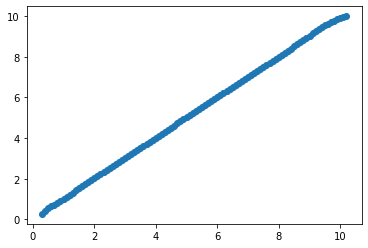

In [123]:
y_pred = model.predict(X)

plt.scatter(Y, y_pred);

In [124]:
y_pred = [model.predict(i) for i in new_data]

y_pred   #유닛 256개를 사용한 모델보다는 성능이 떨어지지만, 파라미터 수를 크게 늘리지 않고도 정답 10.5, 10.7에 가깝게 예측해냈다.

[array([[10.090019],
        [10.128056]], dtype=float32)]

### 장기의존성 문제
RNN은 입력 시퀀스의 길이에 따라 은닉층의 계산이 반복되는데,  
역전파 시 그 미분값이 계속 곱해지면서 경사값이 0에 수렴할 수도 있다.  
따라서 단순 RNN은 기울기소실 문제를 피하기 어려워 실전에서는 잘 사용되지 않는다.  
#### => 셀 구조를 변경한 LSTM 등장
    long short term memory  
단순 RNN과 가장 큰 차이는 순환의 대상으로 출력뿐만 아니라 셀 상태를 같이 feedback하는 것이다.  
이 셀 상태에 담긴 정보는 추가되거나 지워질 수 있는데, 셀 상태가 모두 지워져 0이 되면 LSTM은 출력을 내는 일을 하지 않게 되고,  
셀 상태 정보가 새로 정보를 가지게 되면 출력을 한다.
+ 셀 상태 정보를 통해 장기기억에 도움을 준다.
+ Gate : LSTM 셀 내에서 셀 상태 정보를 변경하는 구조
    + 입력게이트 : 새로운 셀 상태 정보를 추가
    + 출력게이트 : 셀 상태에 tanh 함수를 적용 => 이전 상태와 현재 입력에 대해 sigmoid 함수 적용해 [0,1]사이 값 생성  
    => 출력하려는 신호에 곱해 크기 조절 => 현재의 출력이 얼마나 중요한지를 조절
    + 망각게이트 : 셀 상태를 얼마나 지울지 결정(0이면 모두 망각, 1이면 그대로 전달)


=> LSTM은 셀의 중요한 입력값을 인식해서 장기 상태에 저장하고,  
필요한 기간동안 이를 보존하는 기능과 필요할 때 추출할 수 있는 능력을 학습하는 것이다.

그런데 LSTM은 복잡한 연결구조를 가지고 있고, 이에 따라 사용되는 파라미터의 수도 대폭 늘어날 수밖에 없다.  
#### => 좀 더 단순화된 GRU 등장
    gated recurrent unit, 게이트 순환 유닛
따로 셀 상태를 두지 않고, 단순 RNN과 마찬가지로 하나의 출력만 존재함에도 장기의존성 문제를 비슷하게 해결할 수 있다.  
이를 위해 게이트 제어기를 이용해 망각게이트와 입력게이트를 모두 제어한다.
+ 셀 상태정보가 셀의 출력에 통합되었다.
+ 셀을 구성하는 게이트의 수가 3개에서 2개(리셋게이트, 갱신게이트)로 줄었다.
+ 출력게이트가 사라지고, 리셋게이트와 갱신게이트의 동작에 따라 나온 신호가 그대로 출력된다.


단순RNN, LSTM, GRU의 성능을 비교해보자.

In [125]:
#시퀀스 데이터 생성 함수
def generate_sequence(size, seq_len):
    seq_X = np.empty(shape=(size, seq_len, 1))
    Y = np.empty(shape=(size,))
    
    for i in range(size):
        c = np.linspace(i/10, (i+seq_len-1)/10, seq_len)
        seq_X[i] = c[:, np.newaxis]
        Y[i] = (i+seq_len) / 10
    return seq_X, Y

size, seq_len = 8, 16   #길이가 16인 시퀀스 8개

x_train, y_train = generate_sequence(size, seq_len)
x_train.shape, y_train.shape

((8, 16, 1), (8,))

In [126]:
#검증데이터 생성
half_size, offset = int(size/2), 1.0
x_test = x_train[:half_size] + offset
y_test = y_train[:half_size] + offset

In [127]:
print('훈련데이터')
for i in range(size):
    print(x_train[i].flatten(), y_train[i])
    
print('-' * 70)

print('검증데이터')
for i in range(half_size):
    print(x_test[i].flatten(), y_test[i])

훈련데이터
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5] 1.6
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6] 1.7
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7] 1.8
[0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8] 1.9
[0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9] 2.0
[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ] 2.1
[0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1] 2.2
[0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2] 2.3
----------------------------------------------------------------------
검증데이터
[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5] 2.6
[1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6] 2.7
[1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7] 2.8
[1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8] 2.9


In [128]:
num_units = 256
simple_RNN = keras.Sequential([keras.layers.SimpleRNN(units=num_units, return_sequences=False, input_shape=[seq_len,1]),
                              keras.layers.Dense(1)])
LSTM_model = keras.Sequential([(keras.layers.LSTM(units=num_units, return_sequences=False, input_shape=[seq_len,1])),
                         keras.layers.Dense(1)])
GRU_model = keras.Sequential([(keras.layers.GRU(units=num_units, return_sequences=False, input_shape=[seq_len,1])),
                        keras.layers.Dense(1)])

simple_RNN.compile(optimizer='adam', loss='mse')
LSTM_model.compile(optimizer='adam', loss='mse')
GRU_model.compile(optimizer='adam', loss='mse')

simple_RNN.fit(x_train, y_train, epochs=100, verbose=0)
LSTM_model.fit(x_train, y_train, epochs=100, verbose=0)
GRU_model.fit(x_train, y_train, epochs=100, verbose=0)

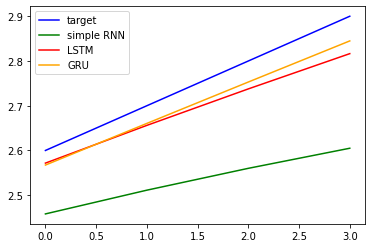

In [129]:
simple_RNN_pred = simple_RNN.predict(x_test)
LSTM_model_pred = LSTM_model.predict(x_test)
GRU_model_pred = GRU_model.predict(x_test)

plt.plot(y_test, color='b', label='target')
plt.plot(simple_RNN_pred, color='g', label='simple RNN')
plt.plot(LSTM_model_pred, color='r', label='LSTM')
plt.plot(GRU_model_pred, color='orange', label='GRU')
plt.legend();

정답인 파란선에 가장 가깝게 예측해낸 건 GRU, LSTM, simple RNN 순이다.

### Quiz.
sin 곡선의 일부분을 잘라 만든 비선형 시퀀스를 보고, 이 시퀀스 다음에 나타날 값을 예측하는 RNN 모델을 만들어보자.

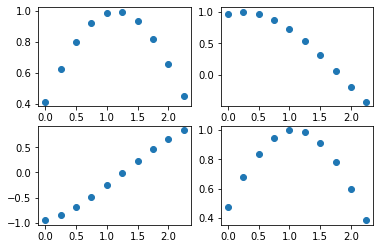

In [130]:
#훈련데이터 생성
size, seq_len = 100, 10
seq_X = np.empty(shape=(size, seq_len, 1))
Y = np.empty(shape=(size,))

interval = np.linspace(0.0, 2.5, seq_len+1)   #sin 곡선에서 잘라낼 구간 설정

shift = np.random.randn(size)                 #시퀀스 추출에 사용할 구간을 옮겨놓는 값
for i in range(size):
    seq_X[i,:,:] = np.sin(shift[i] + interval[:-1]).reshape(seq_len,1)
    Y[i] = np.sin(shift[i] + interval[-1])
    
plt.subplot(2,2,1)
plt.scatter(interval[:-1], seq_X[1,:,:])
plt.subplot(2,2,2)
plt.scatter(interval[:-1], seq_X[3,:,:])
plt.subplot(2,2,3)
plt.scatter(interval[:-1], seq_X[5,:,:])
plt.subplot(2,2,4)
plt.scatter(interval[:-1], seq_X[9,:,:]);

In [131]:
#100개 중 80개는 훈련용, 20개는 검증용으로 분리
x_train = seq_X[:80]
y_train = Y[:80]
x_test = seq_X[80:]
y_test = Y[80:]

In [132]:
simple_RNN = keras.Sequential([(keras.layers.SimpleRNN(units=10, return_sequences=False, input_shape=[seq_len,1])),
                               keras.layers.Dense(1)])
LSTM_model = keras.Sequential([(keras.layers.LSTM(units=10, return_sequences=False, input_shape=[seq_len,1])),
                               keras.layers.Dense(1)])
GRU_model = keras.Sequential([(keras.layers.GRU(units=10, return_sequences=False, input_shape=[seq_len,1])),
                               keras.layers.Dense(1)])

simple_RNN.compile(optimizer='adam', loss='mse')
LSTM_model.compile(optimizer='adam', loss='mse')
GRU_model.compile(optimizer='adam', loss='mse')

print(f'simple RNN 파라미터 개수 : {simple_RNN.count_params()}')
print(f'LSTM 파라미터 개수 : {LSTM_model.count_params()}')
print(f'GRU 파라미터 개수 : {GRU_model.count_params()}')

simple RNN 파라미터 개수 : 131
LSTM 파라미터 개수 : 491
GRU 파라미터 개수 : 401


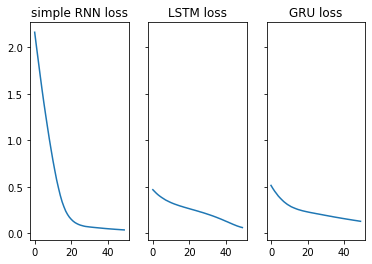

In [133]:
simple_RNN_history = simple_RNN.fit(x_train, y_train, epochs=50, verbose=0)
LSTM_model_history = LSTM_model.fit(x_train, y_train, epochs=50, verbose=0)
GRU_model_history = GRU_model.fit(x_train, y_train, epochs=50, verbose=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.plot(simple_RNN_history.history['loss'])
ax1.set_title('simple RNN loss')
ax2.plot(LSTM_model_history.history['loss'])
ax2.set_title('LSTM loss')
ax3.plot(GRU_model_history.history['loss'])
ax3.set_title('GRU loss');

단순 RNN의 loss가 가장 낮게 나온다.  

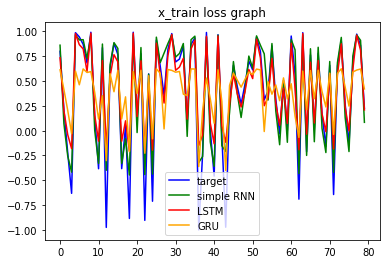

In [134]:
simple_RNN_pred = simple_RNN.predict(x_train)
LSTM_model_pred = LSTM_model.predict(x_train)
GRU_model_pred = GRU_model.predict(x_train)

plt.title('x_train loss graph')
plt.plot(y_train, color='b', label='target')
plt.plot(simple_RNN_pred, color='g', label='simple RNN')
plt.plot(LSTM_model_pred, color='r', label='LSTM')
plt.plot(GRU_model_pred, color='orange', label='GRU')
plt.legend();

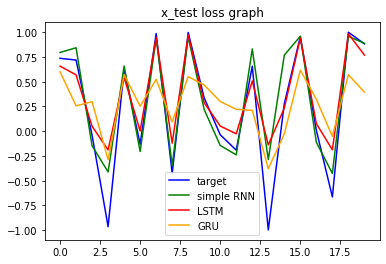

In [135]:
simple_RNN_pred = simple_RNN.predict(x_test)
LSTM_model_pred = LSTM_model.predict(x_test)
GRU_model_pred = GRU_model.predict(x_test)

plt.title('x_test loss graph')
plt.plot(y_test, color='b', label='target')
plt.plot(simple_RNN_pred, color='g', label='simple RNN')
plt.plot(LSTM_model_pred, color='r', label='LSTM')
plt.plot(GRU_model_pred, color='orange', label='GRU')
plt.legend();

세 모델 모두 훈련용, 검증용 데이터에 대해 실제 그래프와 거의 일치하도록 예측해낸 것을 볼 수 있다.  

### Quiz.
기억이 필요한 시퀀스를 예측해보자.  
sin 곡선에서 일부분을 잘라 만든 시퀀스의 각 요소에 임의의 난수 인덱스를 부여하고,  
시퀀스의 각 요소들 가운데 찍수 인덱스를 가진 요소들의 평균값을 계산하는 모델을 만들어보자.

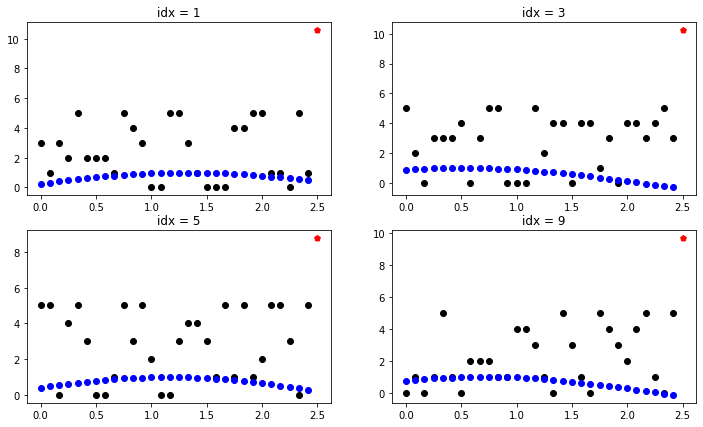

In [136]:
size, seq_len = 200, 30
seq_X = np.empty(shape=(size, seq_len, 2))
Y = np.empty(shape=(size,))

interval = np.linspace(0.0, 2.5, seq_len+1)   #sin 곡선에서 잘라낼 구간 설정

shift = np.random.randn(size)
for i in range(size):
    seq_X[i,:,0] = np.random.randint(0, 6, size=(seq_len))   #0~5 사이 임의의 정수를 인덱스로 지정 => 짝수인 데이터만 골라 sin 곡선에서 얻은 값을 모두 더하면 target
    seq_X[i,:,1] = np.sin(shift[i] + interval[:-1])
    even_idx = seq_X[i, seq_X[i,:,0]%2 == 0]
    Y[i] = even_idx[:,1].sum()
    

plt.figure(figsize=(12,7))
for ax, idx in enumerate([1,3,5,9]):
    plt.subplot(2,2,ax+1)
    plt.title(f'idx = {idx}')
    plt.scatter(interval[:-1], seq_X[idx,:,0], color='black')      #인덱스 정보
    plt.scatter(interval[:-1], seq_X[idx,:,1], color='b')          #sin 곡선에서 추출된 시퀀스 데이터
    plt.scatter(interval[-1], Y[idx], color='r', marker='p');      #target(인덱스 정보가 짝수인 파란 데이터들의 합)

In [137]:
#200개 중 180개는 훈련용, 20개는 검증용으로 분리

x_train = seq_X[:180]
y_train = Y[:180]
x_test = seq_X[180:]
y_test = Y[180:]

In [138]:
simple_RNN = keras.Sequential([(keras.layers.SimpleRNN(units=10, return_sequences=False, input_shape=[seq_len,2])),
                               keras.layers.Dense(1)])
LSTM_model = keras.Sequential([(keras.layers.LSTM(units=10, return_sequences=False, input_shape=[seq_len,2])),
                               keras.layers.Dense(1)])
GRU_model = keras.Sequential([(keras.layers.GRU(units=10, return_sequences=False, input_shape=[seq_len,2])),
                               keras.layers.Dense(1)])

simple_RNN.compile(optimizer='adam', loss='mse')
LSTM_model.compile(optimizer='adam', loss='mse')
GRU_model.compile(optimizer='adam', loss='mse')

print(f'simple RNN 파라미터 개수 : {simple_RNN.count_params()}')
print(f'LSTM 파라미터 개수 : {LSTM_model.count_params()}')
print(f'GRU 파라미터 개수 : {GRU_model.count_params()}')

simple RNN 파라미터 개수 : 141
LSTM 파라미터 개수 : 531
GRU 파라미터 개수 : 431


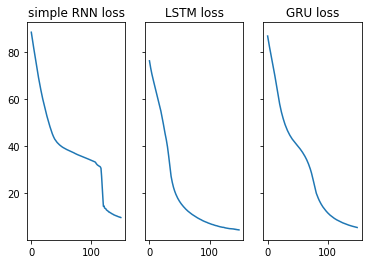

In [139]:
simple_RNN_history = simple_RNN.fit(x_train, y_train, epochs=150, verbose=0)
LSTM_model_history = LSTM_model.fit(x_train, y_train, epochs=150, verbose=0)
GRU_model_history = GRU_model.fit(x_train, y_train, epochs=150, verbose=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.plot(simple_RNN_history.history['loss'])
ax1.set_title('simple RNN loss')
ax2.plot(LSTM_model_history.history['loss'])
ax2.set_title('LSTM loss')
ax3.plot(GRU_model_history.history['loss'])
ax3.set_title('GRU loss');

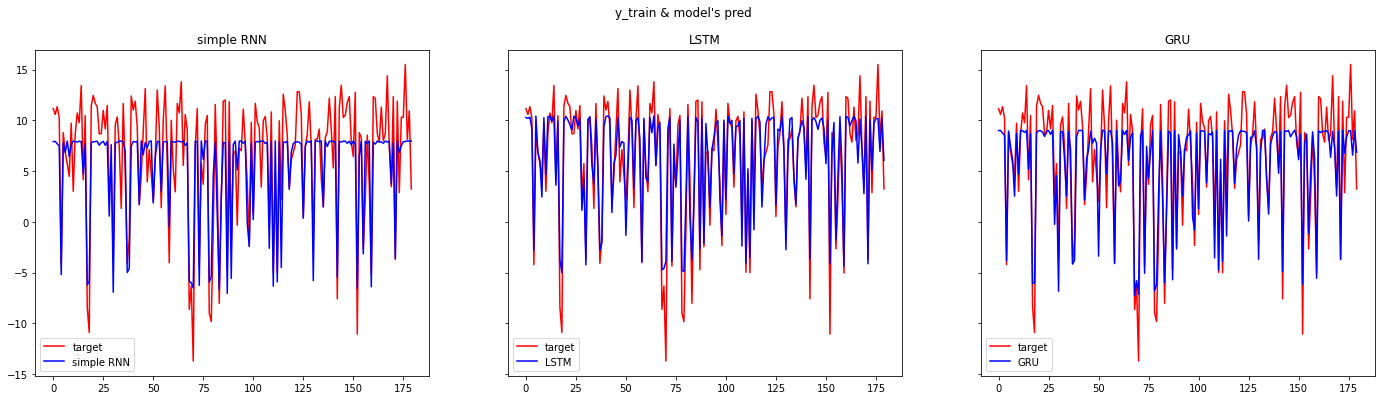

In [140]:
simple_RNN_pred = simple_RNN.predict(x_train)
LSTM_model_pred = LSTM_model.predict(x_train)
GRU_model_pred = GRU_model.predict(x_train)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(24,6))
fig.suptitle("y_train & model's pred")
ax1.set_title('simple RNN')
ax1.plot(y_train, color='r', label='target')
ax1.plot(simple_RNN_pred, color='b', label='simple RNN')
ax1.legend()
ax2.set_title('LSTM')
ax2.plot(y_train, color='r', label='target')
ax2.plot(LSTM_model_pred, color='b', label='LSTM')
ax2.legend(loc='lower left')
ax3.set_title('GRU')
ax3.plot(y_train, color='r', label='target')
ax3.plot(GRU_model_pred, color='b', label='GRU')
ax3.legend(loc='lower left');

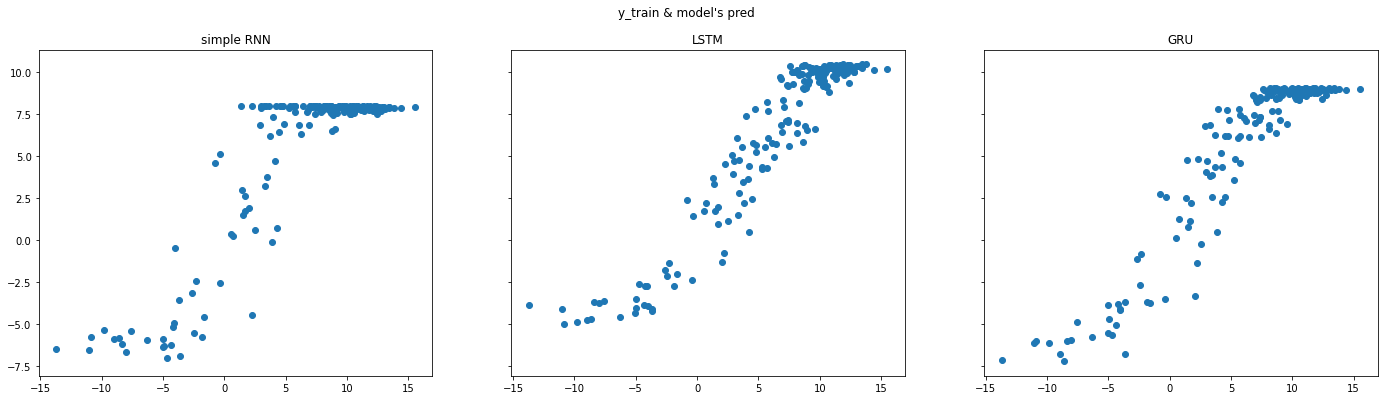

In [141]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(24,6))
fig.suptitle("y_train & model's pred")
ax1.set_title('simple RNN')
ax1.scatter(y_train, simple_RNN_pred)
ax2.set_title('LSTM')
ax2.scatter(y_train, LSTM_model_pred)
ax3.set_title('GRU')
ax3.scatter(y_train, GRU_model_pred);

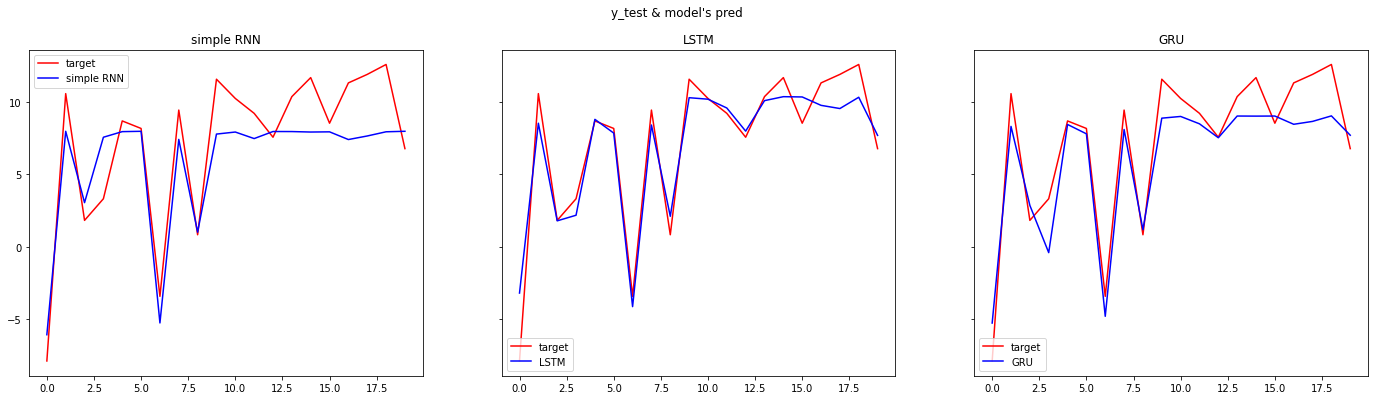

In [142]:
simple_RNN_pred = simple_RNN.predict(x_test)
LSTM_model_pred = LSTM_model.predict(x_test)
GRU_model_pred = GRU_model.predict(x_test)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(24,6))
fig.suptitle("y_test & model's pred")
ax1.set_title('simple RNN')
ax1.plot(y_test, color='r', label='target')
ax1.plot(simple_RNN_pred, color='b', label='simple RNN')
ax1.legend()
ax2.set_title('LSTM')
ax2.plot(y_test, color='r', label='target')
ax2.plot(LSTM_model_pred, color='b', label='LSTM')
ax2.legend(loc='lower left')
ax3.set_title('GRU')
ax3.plot(y_test, color='r', label='target')
ax3.plot(GRU_model_pred, color='b', label='GRU')
ax3.legend(loc='lower left');

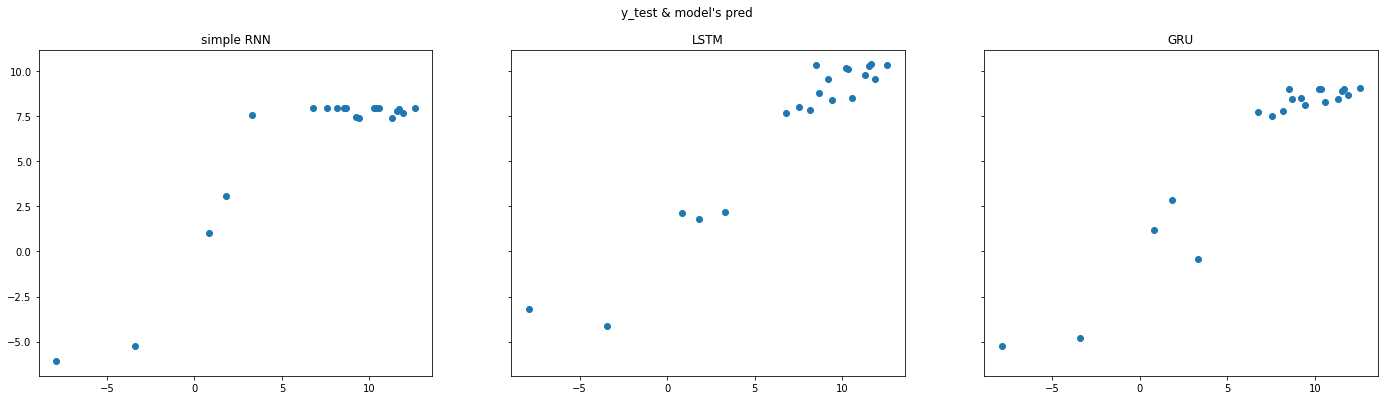

In [143]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(24,6))
fig.suptitle("y_test & model's pred")
ax1.set_title('simple RNN')
ax1.scatter(y_test, simple_RNN_pred)
ax2.set_title('LSTM')
ax2.scatter(y_test, LSTM_model_pred)
ax3.set_title('GRU')
ax3.scatter(y_test, GRU_model_pred);

위처럼 기억력이 필요한 문제에서 세가지 모델을 비교해보면(units=10으로 동일)  
LSTM, GRU는 비슷한 성능을 보이며 단순 RNN은 성능이 확연히 떨어진다.  


units=256으로 증가시켜 세가지 모델을 다시 비교해보자.

In [144]:
simple_RNN = keras.Sequential([(keras.layers.SimpleRNN(units=256, return_sequences=False, input_shape=[seq_len,2])),
                               keras.layers.Dense(1)])
LSTM_model = keras.Sequential([(keras.layers.LSTM(units=256, return_sequences=False, input_shape=[seq_len,2])),
                               keras.layers.Dense(1)])
GRU_model = keras.Sequential([(keras.layers.GRU(units=256, return_sequences=False, input_shape=[seq_len,2])),
                               keras.layers.Dense(1)])

simple_RNN.compile(optimizer='adam', loss='mse')
LSTM_model.compile(optimizer='adam', loss='mse')
GRU_model.compile(optimizer='adam', loss='mse')

print(f'simple RNN 파라미터 개수 : {simple_RNN.count_params()}')
print(f'LSTM 파라미터 개수 : {LSTM_model.count_params()}')
print(f'GRU 파라미터 개수 : {GRU_model.count_params()}')

simple RNN 파라미터 개수 : 66561
LSTM 파라미터 개수 : 265473
GRU 파라미터 개수 : 199937


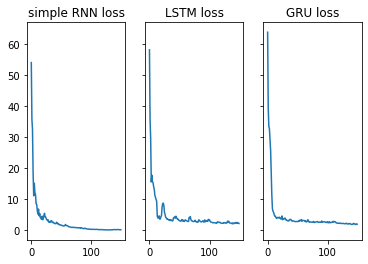

In [145]:
simple_RNN_history = simple_RNN.fit(x_train, y_train, epochs=150, verbose=0)
LSTM_model_history = LSTM_model.fit(x_train, y_train, epochs=150, verbose=0)
GRU_model_history = GRU_model.fit(x_train, y_train, epochs=150, verbose=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.plot(simple_RNN_history.history['loss'])
ax1.set_title('simple RNN loss')
ax2.plot(LSTM_model_history.history['loss'])
ax2.set_title('LSTM loss')
ax3.plot(GRU_model_history.history['loss'])
ax3.set_title('GRU loss');

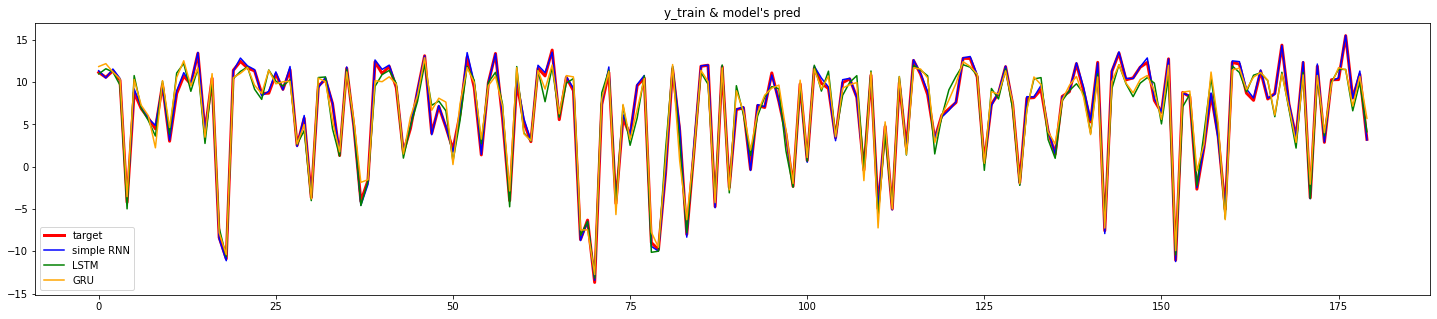

In [149]:
simple_RNN_pred = simple_RNN.predict(x_train)
LSTM_model_pred = LSTM_model.predict(x_train)
GRU_model_pred = GRU_model.predict(x_train)

fig = plt.figure(figsize=(25,5))
plt.title("y_train & model's pred")
plt.plot(y_train, color='r', label='target', linewidth=3)
plt.plot(simple_RNN_pred, color='b', label='simple RNN')
plt.plot(LSTM_model_pred, color='g', label='LSTM')
plt.plot(GRU_model_pred, color='orange', label='GRU')
plt.legend();

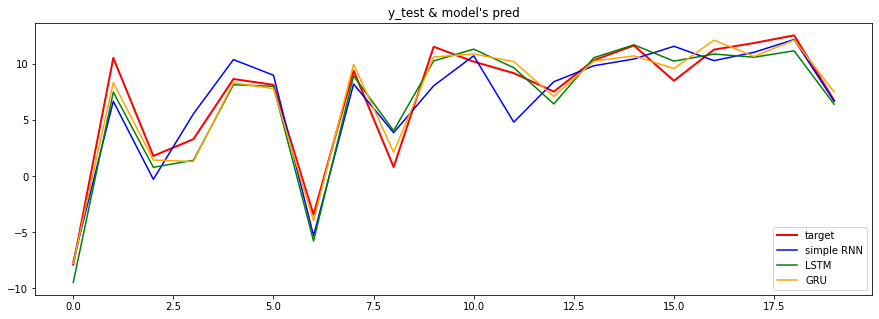

In [147]:
simple_RNN_pred = simple_RNN.predict(x_test)
LSTM_model_pred = LSTM_model.predict(x_test)
GRU_model_pred = GRU_model.predict(x_test)

fig = plt.figure(figsize=(15,5))
plt.title("y_test & model's pred")
plt.plot(y_test, color='r', label='target', linewidth=2)
plt.plot(simple_RNN_pred, color='b', label='simple RNN')
plt.plot(LSTM_model_pred, color='g', label='LSTM')
plt.plot(GRU_model_pred, color='orange', label='GRU')
plt.legend();

    기억력이 필요없는 문제에서는 units를 늘리면 모든 모델의 예측성능은 거의 동일하게 높았지만, 
    기억력이 필요한 문제에서는 units를 늘려도 단순 RNN의 오차는 크게 나온다.
라고 책에 나와있는데 실제로 해보니 훈련데이터에 대한 loss는 거의 차이가 안보이고,  
검증데이터에 대한 예측성능은 LSTM과 GRU에 비해 단순RNN이 아주 약간 오차를 더 보이는 것같다.(흠,,,)